<a href="https://colab.research.google.com/github/QIXIN-ACT/SOCI40133/blob/main/5_Classifying_Meanings_and_Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [ ]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-wee5q5f5
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-wee5q5f5
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [ ]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"


x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations

In [ ]:
anno.labels

In [ ]:
anno.missing_values

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [ ]:
x = np.loadtxt("/content/movie_reviews_ratings_100.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,5)

array([0.18      , 0.23666667, 0.16333333, 0.21333333, 0.20666667])

[[ 6.  7.  0.  0.  2.]
 [ 6. 14.  3.  0.  2.]
 [ 3.  3.  8.  3.  1.]
 [ 1.  0.  6. 12.  4.]
 [ 2.  0.  0.  3. 14.]]


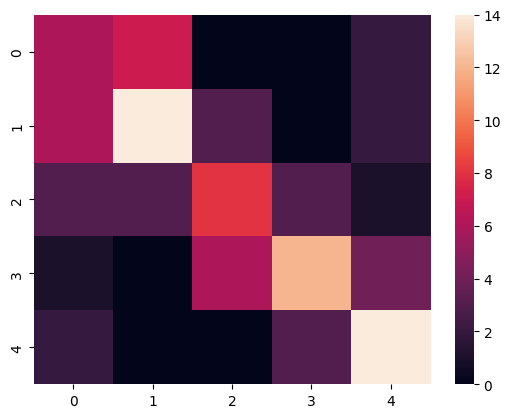

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],5)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.42211055276381915

In [ ]:
fleiss_kappa(anno.annotations[::])

0.4477141502329085

In [ ]:
krippendorffs_alpha(anno.annotations[::])

0.6088108719010794

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.4230528032108366

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.4230528  0.46074743]
 [0.4230528  1.         0.4612879 ]
 [0.46074743 0.4612879  1.        ]]


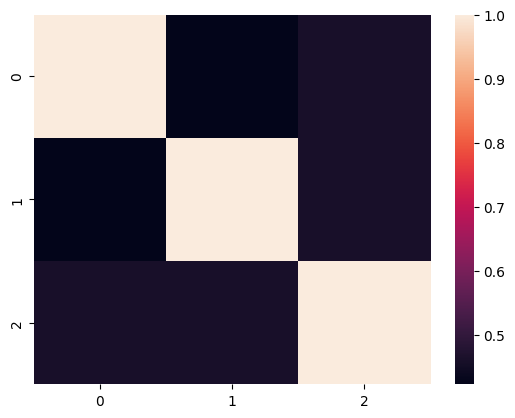

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.4483627100418464

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5691293879102777

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5704451094865404

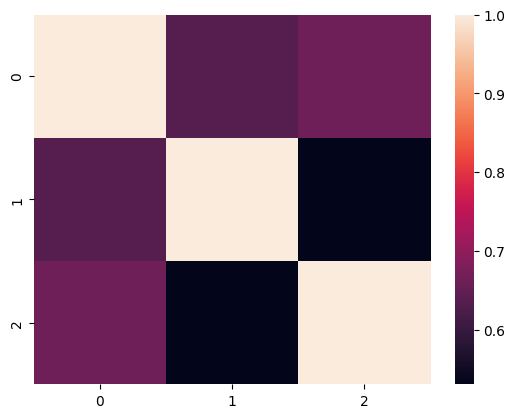

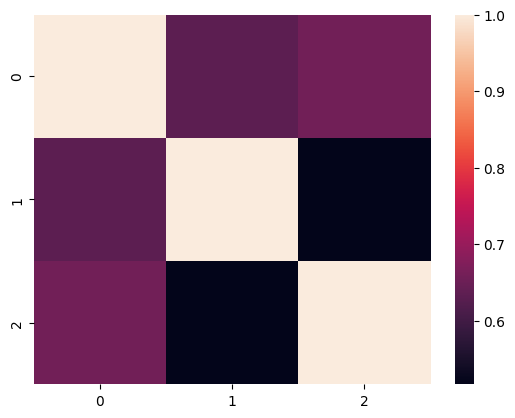

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6103288838485766 0.6022503577588345


The provided analysis indicates that the agreement among three coders who rated movie reviews on a scale from 1 to 5 shows moderate inter-coder reliability based on Cohen's kappa scores ranging from approximately 0.42 to 0.57. This level of agreement suggests that while there is some consistency in the ratings, individual coder interpretations do vary, highlighting the subjective nature of evaluating movie reviews. The heatmap visually confirms this moderate agreement. Consequently, these findings imply that human coding for movie review sentiment is not entirely consistent and may require clearer guidelines or additional training to ensure more reliable assessments. This moderate reliability needs to be accounted for when using human coders to analyze content sentiment in movie reviews.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

,vect,category
746,"[-0.08954747320579205, -0.003449898730416345]",0
634,"[0.03997921412265931, 0.31038714813179513]",0
83,"[0.21152200463636123, 0.831154075257609]",1
803,"[-0.3055788168185547, 0.5202721222815522]",1
814,"[0.019251677257619084, -0.2743097473761395]",0
...,...,...
172,"[0.17174242200570372, -0.24056930424352974]",0
955,"[0.2947519838293617, -0.009471123742411734]",1
594,"[-0.03894293480614656, 0.12738334071189383]",0
516,"[0.14751923850598261, -0.3015077945296424]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


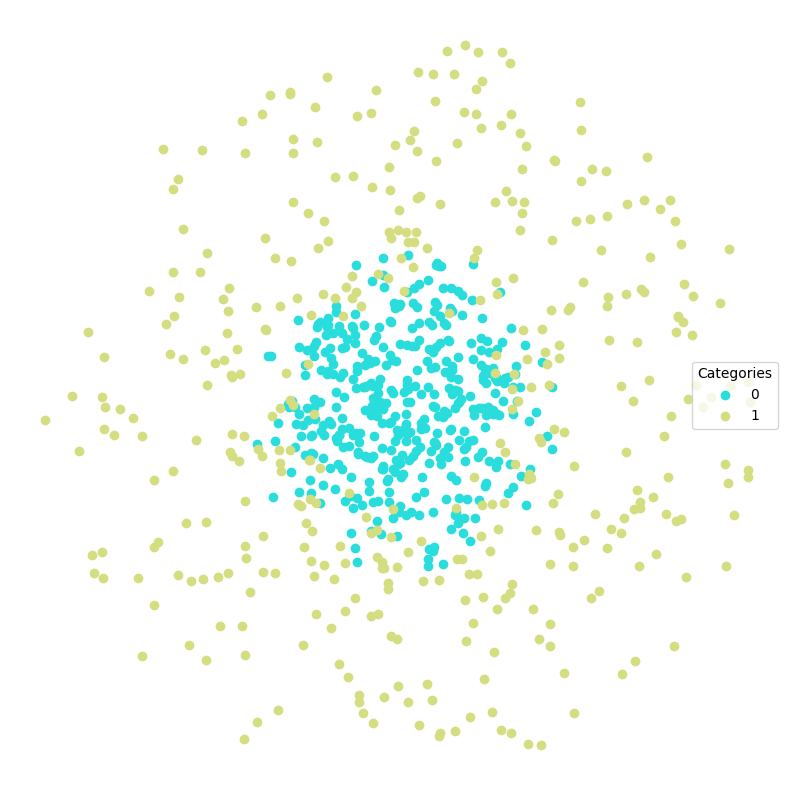

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

415     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
37      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
760     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
418     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
375     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
170     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
619     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
281     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1027    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1221    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: vect, Length: 1278, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.012500,0.976190,1.000000,0.964881,0.952381
Bad Roommates,0.015625,0.975403,0.972222,0.941643,0.958904
Tales From Tech Support,0.031250,0.967001,0.918605,0.894372,0.963415
Relationships,0.015625,0.981378,0.963415,0.945877,0.975309


This lets us look at which classes do better:

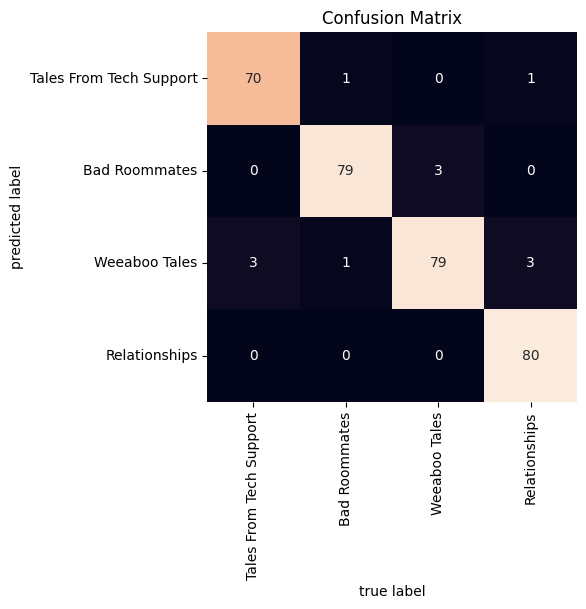

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

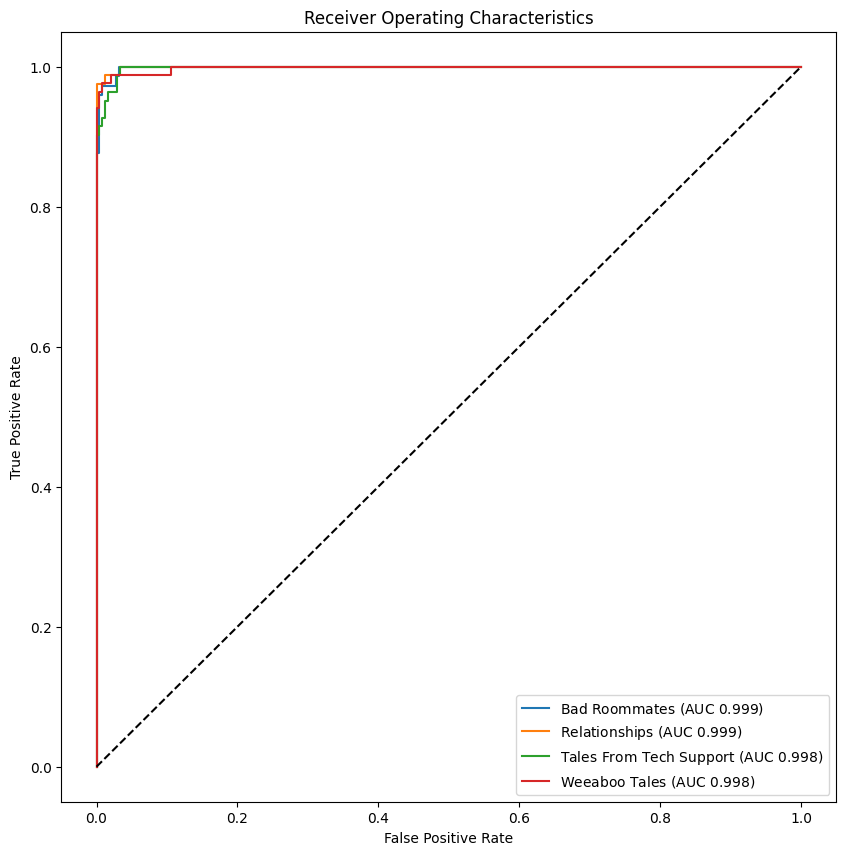

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


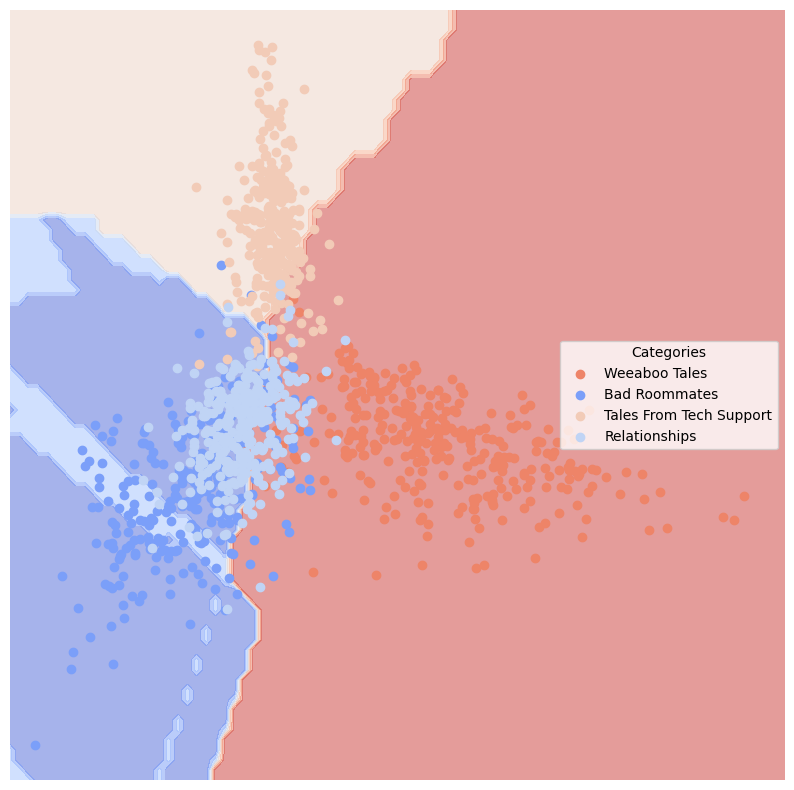

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [ ]:
!git clone https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter.git

Cloning into 'Homework-Notebooks-2024-Winter'...
remote: Enumerating objects: 4108, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4108 (delta 15), reused 40 (delta 12), pack-reused 4060
Receiving objects: 100% (4108/4108), 189.37 MiB | 25.16 MiB/s, done.
Resolving deltas: 100% (150/150), done.
Updating files: 100% (4061/4061), done.


In [ ]:
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)

Loading Reddit data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
dfTest

In [ ]:
#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

DecisionTreeClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.078125,0.917508,0.795455,0.745015,0.909091
Bad Roommates,0.071875,0.892512,0.924051,0.802633,0.811111
Relationships,0.075000,0.903167,0.818182,0.737352,0.863014
Weeaboo Tales,0.043750,0.933333,0.934211,0.857237,0.887500


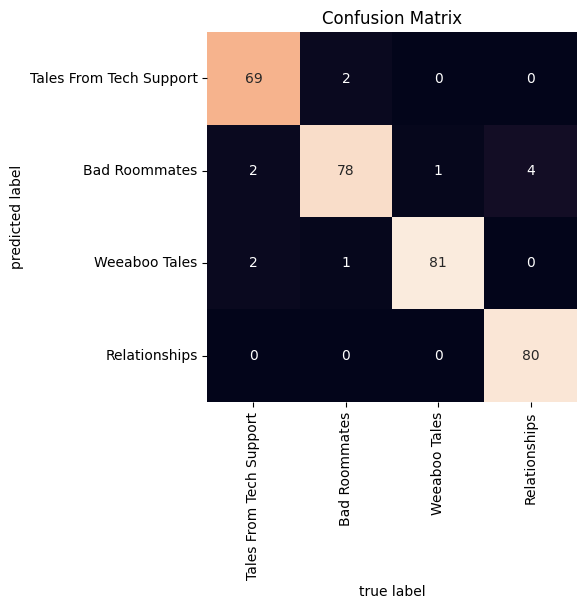

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

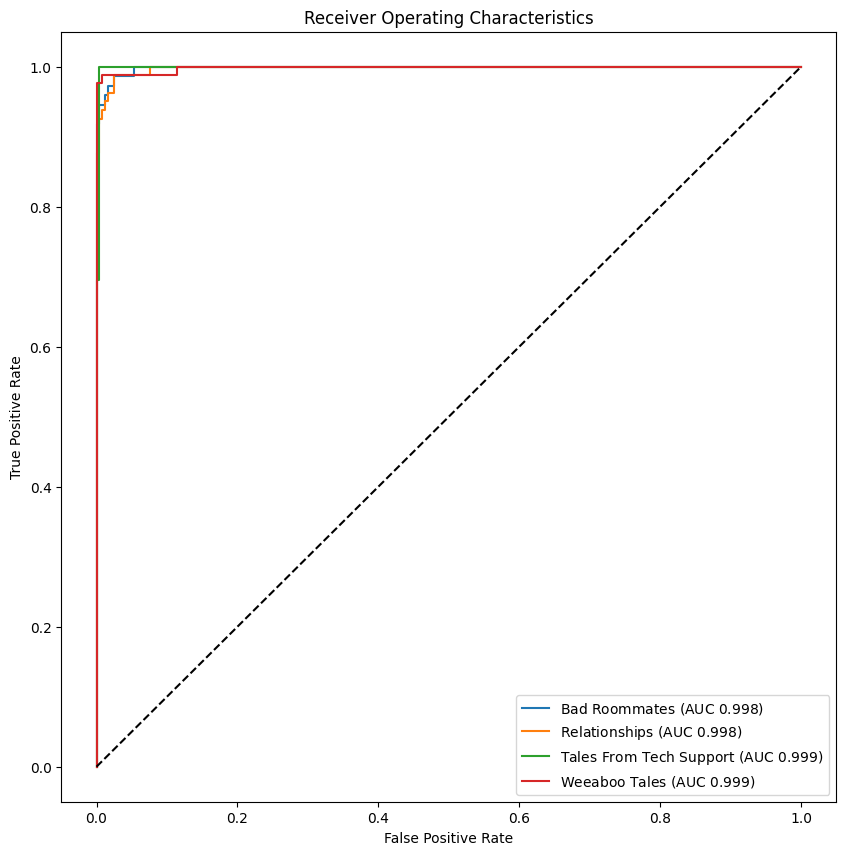

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


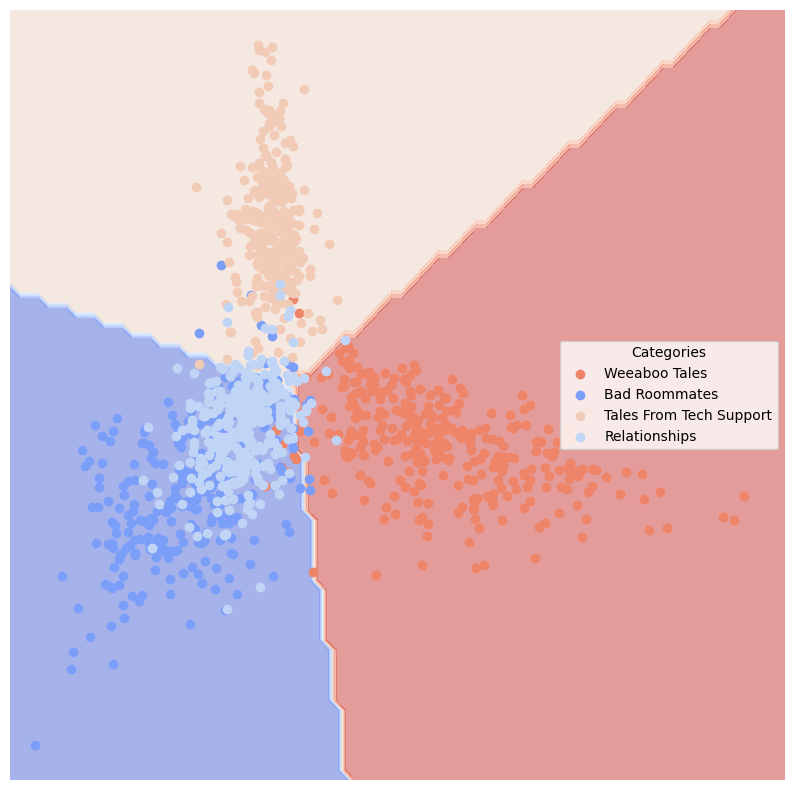

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

**Seems that module 'sklearn' has no attribute 'naive_bayes'**

+ Decision trees or random forests perform well on andSplit and xorSplit datasets because they can model non-linear boundaries.
+ SVMs with non-linear kernels are good for xorSplit and targetSplit datasets due to their ability to model complex boundaries.
+ Neural networks are flexible and can model complex patterns, potentially performing well across all datasets, especially xorSplit and targetSplit, given the right architecture and parameters.
+ Simple models like logistic regression can't perform well on the xorSplit and targetSplit datasets due to their non-linearity.
+ A random dataset doesn't have any pattern, making it difficult for all classifiers to perform better than random guessing.

The evaluation for empirical dataset is attached in [this pdf in google drive](https://drive.google.com/file/d/112kVYxJLsXSwMELBaK5c4TUixGNFXZow/view?usp=sharing)

Gradient Boosting Classifier is highly effective for the Senate Small and Senate Large datasets likely due to its ability to handle complex, non-linear decision boundaries and its robustness to overfitting in datasets with a rich feature set. Logistic Regression Classifier performs well with the Senate Small dataset, probably because it excels in binary classification tasks where relationships between features and outcomes are linear. Random Forest Classifier's success across most datasets can be attributed to its ensemble approach, reducing overfitting while maintaining high accuracy. Linear SVC's performance with the Reddit dataset suggests it effectively handles high-dimensional data spaces, typical of text data. The MLPClassifier's superior performance in the Newsgroups dataset may be due to its deep learning capabilities, which excel in capturing intricate patterns in large-scale textual data. SVC with a polynomial kernel thrives in the Spam dataset, likely because it can model complex relationships through its kernel trick. Decision Trees' effectiveness in the Senate Small dataset could be due to its simplicity and the binary nature of the data. The surprising success of Logistic Regression with the Reddit dataset might be because even simple models can perform well when the data has distinct linear boundaries.

In [ ]:
# Use ExtraTreeClassifier with Reddit dataset
clf = sklearn.ensemble.ExtraTreesClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

ExtraTreesClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.015625,0.980840,0.961538,0.942813,0.974026
Bad Roommates,0.028125,0.966908,0.945055,0.915553,0.955556
Relationships,0.028125,0.957656,0.944444,0.895381,0.931507
Weeaboo Tales,0.009375,0.985417,0.987342,0.968908,0.975000


In [ ]:
# Use DecisionTreeClassifier with Reddit dataset
clf = sklearn.tree.DecisionTreeClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

DecisionTreeClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.078125,0.917508,0.795455,0.745015,0.909091
Bad Roommates,0.071875,0.892512,0.924051,0.802633,0.811111
Relationships,0.075000,0.903167,0.818182,0.737352,0.863014
Weeaboo Tales,0.043750,0.933333,0.934211,0.857237,0.887500


+ The Extra Trees classifier is an ensemble learning method that fits a number of randomized decision trees on various sub-samples of the dataset and uses averaging to improve predictive accuracy and control overfitting. As evident from the provided images, the Extra Trees classifier was implemented and its performance was evaluated on different datasets.

+ From the information in the images, it appears that the Extra Trees classifier performed quite well compared to some of the other classifiers such as DecisionTreeClassifier. This could be due to Extra Trees creating a larger diversity among the individual trees, which can provide a more generalized model. The ensemble nature of Extra Trees helps to reduce the variance of the model, leading to better performance on unseen data.

+ Compared to the other classifiers, the Extra Trees classifier tends to perform better on more complex datasets due to its randomness and ensemble approach. It is less likely to overfit compared to a single decision tree and is robust to noise. In your case, the metrics like AUC, Precision, and Recall are generally higher for the Extra Trees classifier than for the Decision Tree, indicating better performance on the datasets used.

In [ ]:
# Use ExtraTreeClassifier with artificial dataset (targetSplit)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
clf = sklearn.ensemble.ExtraTreesClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

ExtraTreesClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.16,0.839736,0.836538,0.788518,0.852941
1,0.16,0.839736,0.843750,0.782385,0.826531


In [ ]:
# Use DecisionTreeClassifier with artificial dataset (targetSplit)
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

DecisionTreeClassifier()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.13,0.871679,0.907216,0.845334,0.838095
1,0.13,0.871679,0.834951,0.800851,0.905263


In the artificial dataset, the DecisionTreeClassifier shows a lower error rate and higher AUC in both categories, indicating better overall performance for this particular dataset. The Precision, Average Precision, and Recall also show some differences, with the DecisionTreeClassifier having a higher Precision and Average Precision for Category 0, and a higher Recall for Category 1. These metrics suggest that the DecisionTreeClassifier may be better at correctly identifying true positives in Category 0 and covering the actual positive instances in Category 1 for this dataset.

The ExtraTreesClassifier, while generally more robust due to its ensemble nature, does not outperform the DecisionTreeClassifier in this specific case. This could be due to various factors, including the nature of the dataset, the way the trees are constructed, and the randomness injected in the ExtraTreesClassifier not providing a significant advantage. It's also possible that the DecisionTreeClassifier is a better fit for the underlying patterns in this particular dataset, or that it could be overfitting to the training data resulting in seemingly better performance metrics.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [ ]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [ ]:
type(ObamaClintonReleases)

It's a DataFrame! and it looks like this:

In [ ]:
ObamaClintonReleases

Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [ ]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [ ]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect('/content/drive/MyDrive/organizedData.sqlite3')

query = """
SELECT * FROM StoryHeaders
JOIN Chapters ON StoryHeaders.id = Chapters.storyId
WHERE StoryHeaders.language = 1;
"""

# Turn it to dataframe
df = pd.read_sql_query(query, conn)

conn.close()

In [39]:
df.head()

,id,processDate,rating,finished,title,description,curChapters,maxChapters,language,words,...,bookmarks,date,restricted,headerScrapedFrom,contentScrapedFrom,hidden,storyId,idx,textRaw,text
0,50400,2020-07-29 21:39:24,3,1,Raw,"He isn't like that, he repeats to himself, tha...",1,1,1,830,...,8,2010-01-13,0,26302993,26302993,0,50400,0,"<div class=""userstuff""><p>Julius wakes up, swe...","Julius wakes up, sweating. What the hell was t..."
1,131040,2020-07-29 21:42:53,0,1,When in Rome,Making a new life for themselves in the capita...,1,1,1,9511,...,0,2007-10-31,0,26366174,26366174,0,131040,0,"<div class=""userstuff""><table><br/><tbody><br/...",Sesithacus looked gloomily at the doorway lead...
2,231840,2020-07-29 21:46:20,0,1,Alive,"The Kobayashi Maru was a devious, almost bruta...",1,1,1,2202,...,1,2011-07-31,0,26443601,26443601,0,231840,0,"<div class=""userstuff""><p>Alive.</p><p>Chapter...",Alive.\n\nChapter 1\n\nCommander Spock was wal...
3,292320,2020-07-29 21:47:59,2,1,A Mistletoe Projectile,Mistletoe verses Jeeves,1,1,1,2912,...,5,2011-12-10,0,26487424,26487424,0,292320,0,"<div class=""userstuff""><p>Leaving the lift, I ...","Leaving the lift, I forced myself to not whist..."
4,307440,2020-07-29 21:48:22,0,1,A Family Moment. I,In which names are discussed and Blue nearly d...,1,1,1,602,...,2,2011-12-30,0,26498950,26498950,0,307440,0,"<div class=""userstuff""><p>“Why are we hiding?”...","“Why are we hiding?” Blue asks, peering up at ..."


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


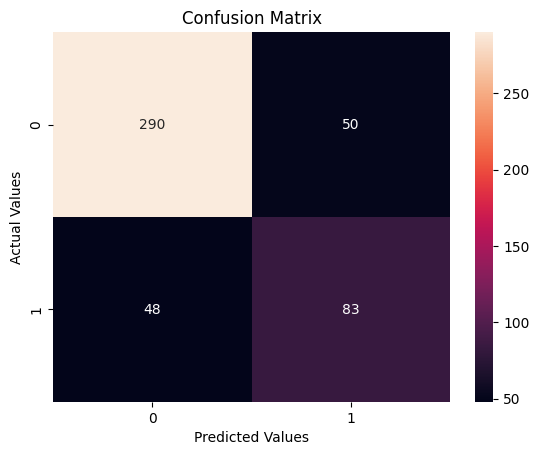

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       340
           1       0.62      0.63      0.63       131

    accuracy                           0.79       471
   macro avg       0.74      0.74      0.74       471
weighted avg       0.79      0.79      0.79       471

AUC: 0.8635383924562191


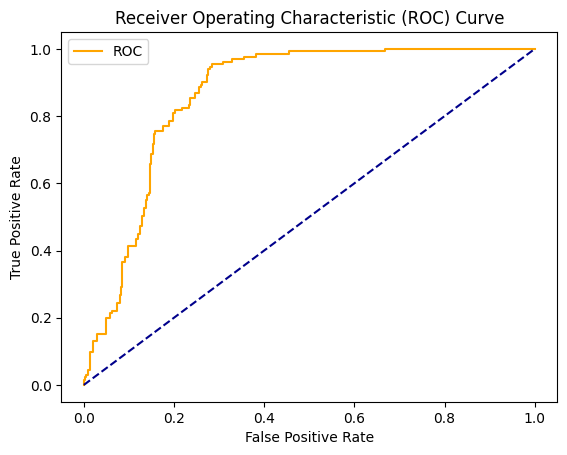

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant features and target
X = df[['rating', 'hits', 'kudos', 'comments', 'bookmarks']]  # Related features
y = df['finished']  # Target variable

# Split into training, testing, and uncoded dataset
coded_data = df[df['coded_flag'] == 1]
uncoded_data = df[df['coded_flag'] == 0]

X_coded = coded_data[['rating', 'maxChapters', 'hits', 'kudos', 'comments', 'bookmarks']]
y_coded = coded_data['finished']
X_uncoded = uncoded_data.drop[['rating', 'maxChapters', 'hits', 'kudos', 'comments', 'bookmarks']]

# Further split coded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_coded, y_coded, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Calculate precision, recall, F-measure, and AUC
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# ROC Curve visualization
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Predict on uncoded data
y_uncoded_pred = model.predict(X_uncoded)

# Add predictions to the uncoded dataframe
uncoded_data['predicted_target'] = y_uncoded_pred

+ The classifier is better at predicting class 0 than class 1, with a higher precision, recall, and F1-score for class 0.

+ The accuracy of the model is reasonably high at 79%.

+ The AUC of the ROC curve suggests that the model has a good ability to distinguish between the classes, despite the lower performance metrics for class 1.

There may be a class imbalance given that there are more instances of class 0 than class 1, which could be influencing the performance metrics. It's often the case that classifiers perform better on the majority class.
In conclusion, while the classifier shows a good ability to differentiate between the classes in general, it does have a bias towards the majority class (class 0).

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification:

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [61]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [62]:
X_train.head()

,rating,hits,kudos,comments,bookmarks
575,0,2803,127,85,16
1538,0,1456,95,4,17
952,3,64713,906,853,121
565,3,240,4,1,1
297,1,3733,165,9,23


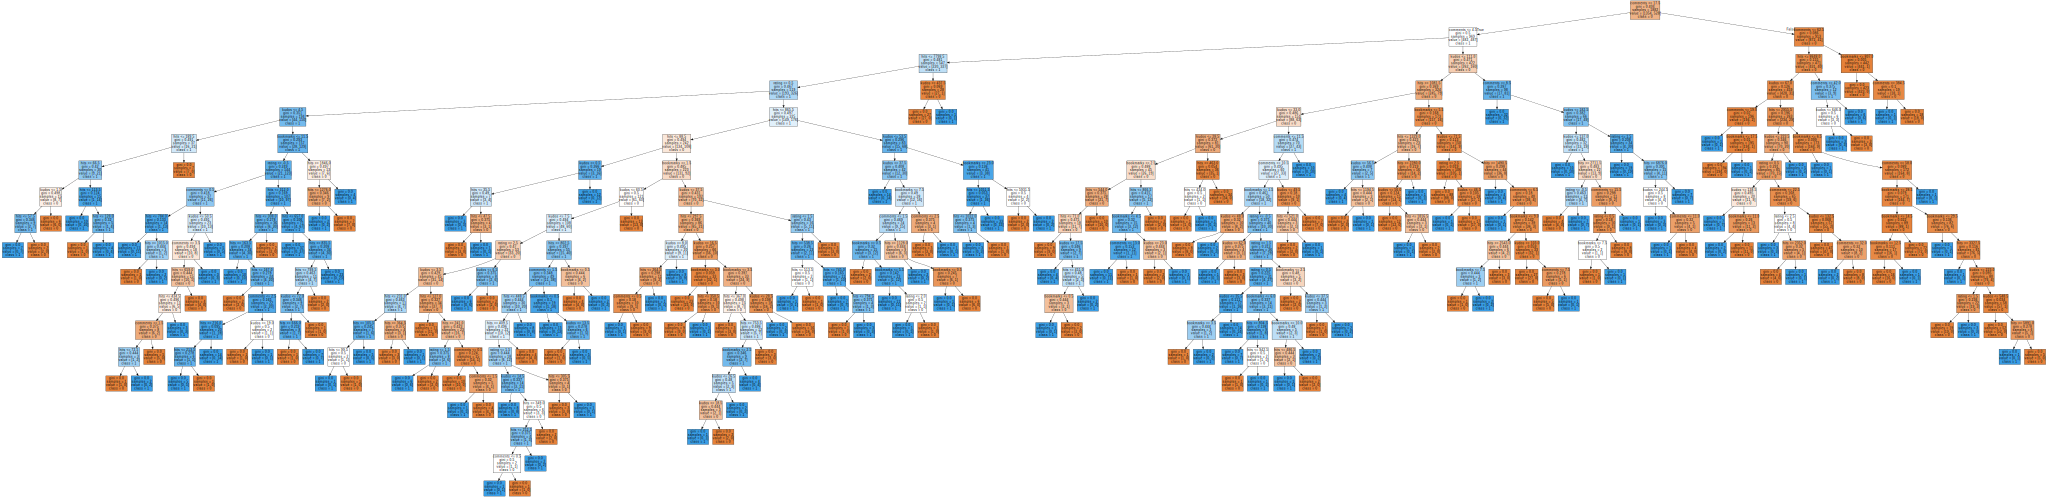

In [66]:
from sklearn.tree import export_graphviz
import graphviz

# Visualize the decision tree
dot_data = export_graphviz(dt_classifier, out_file=None,
                           feature_names=X_train.columns,
                           class_names=[str(x) for x in y_train.unique()],
                           filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

In [67]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

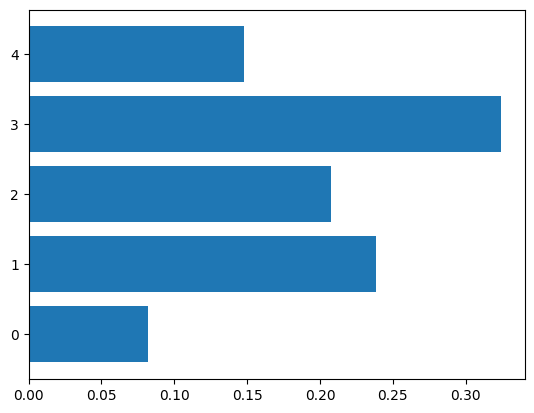

In [68]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_classifier.feature_importances_

# Plot them
plt.barh(range(len(importances)), importances)
plt.show()


In [69]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on the test data
dt_predictions = dt_classifier.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)

# Print classification report for decision tree
print(classification_report(y_test, dt_predictions))

# Print classification report for random forest
print(classification_report(y_test, rf_predictions))

# Calculate AUC for decision tree
dt_auc = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])
print(f'Decision Tree AUC: {dt_auc}')

# Calculate AUC for random forest
rf_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print(f'Random Forest AUC: {rf_auc}')

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       340
           1       0.91      0.74      0.82       131

    accuracy                           0.91       471
   macro avg       0.91      0.86      0.88       471
weighted avg       0.91      0.91      0.90       471

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       340
           1       0.90      0.85      0.88       131

    accuracy                           0.93       471
   macro avg       0.92      0.91      0.91       471
weighted avg       0.93      0.93      0.93       471

Decision Tree AUC: 0.8555231252806466
Random Forest AUC: 0.979928154467894


Random Forest model performs better than Decision Tree model.

Ensemble learning, particularly random forests, works by creating a 'forest' of decision trees, each trained on random subsets of the data and features. This process is known as bootstrap aggregating, or "bagging". Each tree in the forest makes its own predictions, and the random forest algorithm takes the majority vote (for classification tasks) or average prediction (for regression tasks) of all trees to make the final prediction.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [70]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [73]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# Plot the decision boundary by assigning a color to each point in the mesh
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("K-Nearest Neighbors classification")

plt.show()

InvalidIndexError: (slice(None, None, None), 0)

The visualization can't work - this is typically only feasible with two features to keep the visualization two-dimensional.

In [74]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on the test data
knn_predictions = knn_classifier.predict(X_test)

# Print classification report for KNN
print(classification_report(y_test, knn_predictions))

# If the target is binary, calculate AUC
if len(y_train.unique()) == 2:
    knn_auc = roc_auc_score(y_test, knn_classifier.predict_proba(X_test)[:, 1])
    print(f'KNN AUC: {knn_auc}')

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       340
           1       0.79      0.63      0.70       131

    accuracy                           0.85       471
   macro avg       0.83      0.78      0.80       471
weighted avg       0.84      0.85      0.84       471

KNN AUC: 0.8794454422990571


+ K-Nearest Neighbors is a supervised learning algorithm used for classification (and regression) that predicts the label of a data point by looking at the 'k' closest labeled data points and taking a majority vote (for classification).

+ K-Means Clustering is an unsupervised learning algorithm used for clustering. It partitions the data into 'k' clusters, each with a centroid, such that each data point belongs to the cluster with the nearest centroid.

While both algorithms use the concept of 'k' to define how many neighbors or clusters to consider, their applications are different: KNN is used for predictive tasks where the labels are known, while k-means is used for exploratory data analysis to identify patterns or groupings when the labels are unknown.

Both depend heavily on the concept of distance to determine similarity, with **closer points being considered more similar than those further away**. However, the way they use this distance differs: KNN uses distance to make predictions based on nearest neighbors, while k-means uses distance to minimize variance within clusters around centroids.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Create the MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=300)

# Train the model on the training data
mlp.fit(X_train, y_train)

# Predict on the test data
y_pred = mlp.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Binarize the output for multi-class ROC AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_proba = mlp.predict_proba(X_test)

# Check if y_test_binarized needs to be adjusted for two classes
if y_test_binarized.shape[1] == 1:
    y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))

# Calculate ROC AUC
auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc}')

Precision: 0.7768006029671921
Recall: 0.6815286624203821
F1-Score: 0.6980492343924342
AUC: 0.7617198024247869


A neural network classification, such as an MLP, is generally more capable of capturing complex, nonlinear relationships in data compared to k-nearest neighbors (KNN), logistic regression, and decision trees. However, it typically requires more data and computational resources, and it is less interpretable due to its "black box" nature.

+ MLP vs. KNN: MLPs can handle high-dimensional data better than KNN and do not require scaling of the data. KNN can struggle with high dimensionality and is sensitive to irrelevant features.

+ MLP vs. Logistic Regression: Logistic regression is linear and may underperform on non-linear data, whereas MLPs can capture non-linearity. However, logistic regression models are easier to interpret and can be a better choice when interpretability is important.

+ MLP vs. Decision Trees: Decision trees can also capture non-linear relationships and are very interpretable, but they are more prone to overfitting compared to MLPs. MLPs can generalize better with enough data and proper regularization.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [84]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [88]:
import pandas as pd

# Add new columns to the DataFrame for storing results
df['title_emotion'] = None
df['description_emotion'] = None

# Iterate over the DataFrame rows
for index, row in df.iterrows():

    title_result = nlp(row['title'])[0]
    description_result = nlp(row['description'])[0]

    # Assign the results to the appropriate columns
    df.at[index, 'title_emotion'] = title_result
    df.at[index, 'description_emotion'] = description_result


In [89]:
df.head()

,id,processDate,rating,finished,title,description,curChapters,maxChapters,language,words,...,restricted,headerScrapedFrom,contentScrapedFrom,hidden,storyId,idx,textRaw,text,title_emotion,description_emotion
0,50400,2020-07-29 21:39:24,3,1,Raw,"He isn't like that, he repeats to himself, tha...",1,1,1,830,...,0,26302993,26302993,0,50400,0,"<div class=""userstuff""><p>Julius wakes up, swe...","Julius wakes up, sweating. What the hell was t...","{'label': 'POSITIVE', 'score': 0.9969513416290...","{'label': 'NEGATIVE', 'score': 0.9933003187179..."
1,131040,2020-07-29 21:42:53,0,1,When in Rome,Making a new life for themselves in the capita...,1,1,1,9511,...,0,26366174,26366174,0,131040,0,"<div class=""userstuff""><table><br/><tbody><br/...",Sesithacus looked gloomily at the doorway lead...,"{'label': 'POSITIVE', 'score': 0.9897416830062...","{'label': 'POSITIVE', 'score': 0.9994503855705..."
2,231840,2020-07-29 21:46:20,0,1,Alive,"The Kobayashi Maru was a devious, almost bruta...",1,1,1,2202,...,0,26443601,26443601,0,231840,0,"<div class=""userstuff""><p>Alive.</p><p>Chapter...",Alive.\n\nChapter 1\n\nCommander Spock was wal...,"{'label': 'POSITIVE', 'score': 0.9998559951782...","{'label': 'POSITIVE', 'score': 0.9010120630264..."
3,292320,2020-07-29 21:47:59,2,1,A Mistletoe Projectile,Mistletoe verses Jeeves,1,1,1,2912,...,0,26487424,26487424,0,292320,0,"<div class=""userstuff""><p>Leaving the lift, I ...","Leaving the lift, I forced myself to not whist...","{'label': 'NEGATIVE', 'score': 0.9950036406517...","{'label': 'POSITIVE', 'score': 0.8900046348571..."
4,307440,2020-07-29 21:48:22,0,1,A Family Moment. I,In which names are discussed and Blue nearly d...,1,1,1,602,...,0,26498950,26498950,0,307440,0,"<div class=""userstuff""><p>“Why are we hiding?”...","“Why are we hiding?” Blue asks, peering up at ...","{'label': 'POSITIVE', 'score': 0.9997345805168...","{'label': 'NEGATIVE', 'score': 0.9996503591537..."


The utilization of BERT's pipeline functions for emotion analysis offers a novel avenue to explore the emotional dynamics present in titles and descriptions, shedding light on how emotions are strategically employed by writers. This approach enables a deeper understanding of the emotional impact and the intent behind the use of specific emotional cues in text, presenting a nuanced perspective that differs from traditional methods by leveraging advanced natural language processing techniques to dissect and interpret the subtleties of emotional expression in written content.